# Scalable GP Regression (w/ KISS-GP)

## Introduction

If the function you are modeling has additive structure across its dimensions, then SKI can be one of the most efficient methods for your problem.

Here, we model the kernel as a sum of kernels that each act on one dimension. Additive SKI (or KISS-GP) can work very well out-of-the-box on larger datasets (100,000+ data points) with many dimensions. This is a strong assumption though, and may not apply to your problem.

This is the same as [the KISSGP Kronecker notebook](./KISSGP_Kronecker_Regression.ipynb), but applied to more dimensions.

In [1]:
# Imports
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

# Inline plotting
%matplotlib inline

### Set up train data

Here we're learning a simple sin function - but in 2 dimensions

In [2]:
# We store the data as a 10k 1D vector
# It actually represents [0,1]x[0,1] in cartesian coordinates
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        # Each coordinate varies from 0 to 1 in n=100 steps
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)

train_x = train_x.cuda()
train_y = torch.sin(train_x[:, 0]) + torch.cos(train_x[:, 1]) * (2 * math.pi) + torch.randn_like(train_x[:, 0]).mul(0.01)

## The model

As with the Kronecker example case, applying SKI to a multidimensional kernel is as simple as wrapping that kernel with a `GridInterpolationKernel`. You'll want to be sure to set `num_dims` though!

To use an additive decomposition of the kernel, wrap it in an `AdditiveStructureKernel`.

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use, especially with an additive function!).

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then GPyTorch automatically chooses the best bounds for you.

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(
                    gpytorch.kernels.RBFKernel(ard_num_dims=2),
                ), grid_size=grid_size, num_dims=2
            ), num_dims=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood).cuda()

## Train the model hyperparameters


In [4]:
# Optimize the model
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)
num_iter = 20

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Sometimes we get better performance on the GPU when we don't use Toeplitz math
# for SKI. This flag controls that
with gpytorch.settings.use_toeplitz(False):
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.data[0]))
        optimizer.step()

Iter 1/20 - Loss: 0.923
Iter 2/20 - Loss: 0.872
Iter 3/20 - Loss: 0.822
Iter 4/20 - Loss: 0.772
Iter 5/20 - Loss: 0.722
Iter 6/20 - Loss: 0.673
Iter 7/20 - Loss: 0.622
Iter 8/20 - Loss: 0.572
Iter 9/20 - Loss: 0.522
Iter 10/20 - Loss: 0.473
Iter 11/20 - Loss: 0.423
Iter 12/20 - Loss: 0.373
Iter 13/20 - Loss: 0.322
Iter 14/20 - Loss: 0.273
Iter 15/20 - Loss: 0.222
Iter 16/20 - Loss: 0.173
Iter 17/20 - Loss: 0.123
Iter 18/20 - Loss: 0.073
Iter 19/20 - Loss: 0.023
Iter 20/20 - Loss: -0.027


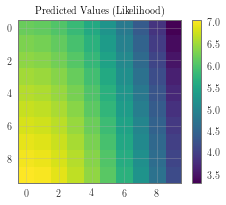

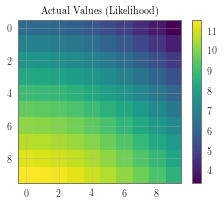

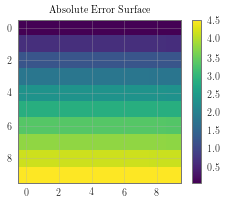

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Create 100 test data points
# Over the square [0,1]x[0,1]
n = 10
test_x = torch.zeros(int(pow(n, 2)), 2).cuda()
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calculate the true test values
test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
test_y_actual = test_y_actual.view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Make a plot of the predicted values
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels.cpu(), 'Predicted Values (Likelihood)')
# Make a plot of the actual values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual.cpu(), 'Actual Values (Likelihood)')
# Make a plot of the errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y.cpu(), 'Absolute Error Surface')